<a href="https://colab.research.google.com/github/hrishipoola/Gun_Sales_Structural_Break/blob/main/Gun_Sales_Structural_Break.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gun Sales: Quantifying a Time Series Structural Break

## Table of Contents

1. Introduction
2. Install & Import Packages
3. Access NICS Background Checks Data
4. Missing Values
5. National Gun Sales
6. Population-Adjusted Sales
7. Rolling Mean and Standard Deviation
8. Rolling Mean and Yearly Average
9. Chow Test
10. Volatility
11. References




## 1. Introduction

In a [previous post](https://crawstat.com/2020/12/15/guns-time-series-analysis-and-forecast/), we explored and visualized population-adjusted gun sales, looking at many dimensions of time series data. We also fit a prediction and forecast applying the Box-Jenkins framework of identification (including stationarizing), estimation (SARIMAX), and model diagnostics.
 
Today, we'll focus specifically on the structural break in the gun sales time series data. The purpose is to:

- Visualize time series dimensions (rolling, yearly average, volatility),including a structural uptick in gun sales and volatility beginning 2012
- Quantify this structural break using [chow test](https://en.wikipedia.org/wiki/Chow_test) and looking at volatility.

For the chow test, our null hypothesis is that there's difference between two sub-periods. We'll run three regressions of sales with year, one over the whole time period (pooled), one before the breakpoint, and one after the breakpoint and take the sum of squared residuals for each. The chow test follows an f distribution with k degrees of freedom in the numerator and N1+N2-2k degrees of freedom in the denominator. After calculating the chow statistic, we see that it is above the critical value, meaning we can reject our null hypothesis and accept our alternative hypothesis of a structural break. Structural changes are often also accompanies by changes in volatility - we'll visualize volatility and % change in volatility to further illustrate the structural break. 

Background check data originates from the [FBI's National Instant Criminal Background Check System (NICS)](https://www.fbi.gov/services/cjis/nics). Original data is available as a [pdf](https://www.fbi.gov/file-repository/nics_firearm_checks_-_month_year_by_state_type.pdf/view). If you'd like to extract the csv from the pdf directly, you can do so using BuzzFeed's [parsing scripts](https://github.com/BuzzFeedNews/nics-firearm-background-checks/tree/master/scripts) or [Tabula](https://tabula.technology/). According to the data pdf, "These statistics represent the number of firearm background checks initiated through the NICS. They do not represent the number of firearms sold. Based on varying state laws and purchase scenarios, a one-to-one correlation cannot be made between a firearm background check and a firearm sale." Important things to keep in mind for our analysis:

- We focus on background checks by month, state, and gun type, namely long guns, which include rifles and shot guns, and handguns.
- We exclude permit check/recheck as regulations vary widely by state
- Also excluded are 'other' gun background checks
- FBI's NICS data only include licensed commercial gun sales and exclude private gun sale, which often don't undergo a background check and represent a sizeable portion of total gun sales. Additionally, many background checks are carried out for concealed carry permits, not gun sales (e.g., Kentucky runs a new check on each concealed carry license holder each month).

To convert background checks to sales (number of units), we apply the multiple gun sales factor (MGSF) multiplier found in Jurgen Brauer's [Small Arms Survey](http://www.smallarmssurvey.org/fileadmin/docs/F-Working-papers/SAS-WP14-US-Firearms-Industry.pdf), which is based on interviews with gun shop owners: multiply background checks for handguns by 1.1, long guns by 1.1, and multiple guns by 2 (page 44). Because state laws and individual transactions differ, sales between states cannot be directly compared. Despite those caveats, the FBI’s NICS numbers are widely accepted as the best proxy for total gun sales in a given time period. Additionally, to adjust sales for population growth, we'll pull monthly U.S. population data from [Federal Reserve Economic Data (FRED)](https://fred.stlouisfed.org/).

Future areas to explore include factors behind the structural change, including shifts in background check reporting and policies among states, economic shocks, legislation, and political change and uncertainty. 

Lets' dig in!

## 2. Install & Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as mtick
%matplotlib inline
!pip install seaborn --upgrade
import seaborn as sns
from datetime import datetime
from datetime import date
from random import randint
import plotly.express as px

# Regression
import statsmodels.api as sm

# F distribution critical value
import scipy.stats

# Access FRED data
!pip install pandas-datareader
from pandas_datareader.data import DataReader

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Infer NaN values
pd.options.mode.use_inf_as_na = True

# Set seaborn plot style
sns.set_style("darkgrid")

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.11.1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



## 3. Access NICS Background Checks Data

In [2]:
# Read in data
guns = pd.read_csv('https://raw.githubusercontent.com/BuzzFeedNews/nics-firearm-background-checks/master/data/nics-firearm-background-checks.csv')

# Check first and last 5 rows
pd.concat([guns.head(), guns.tail()])

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,prepawn_long_gun,prepawn_other,redemption_handgun,redemption_long_gun,redemption_other,returned_handgun,returned_long_gun,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2020-12,Alabama,33421.0,505.0,31103.0,28933.0,1855.0,1388,0.0,43.0,13.0,1.0,2447.0,1121.0,9.0,25.0,0.0,0.0,0.0,0.0,30.0,23.0,5.0,2.0,3.0,0.0,100927
1,2020-12,Alaska,441.0,3.0,3658.0,3822.0,430.0,233,0.0,0.0,0.0,0.0,123.0,84.0,1.0,49.0,31.0,0.0,0.0,0.0,9.0,10.0,1.0,0.0,1.0,0.0,8896
2,2020-12,Arizona,9043.0,846.0,25093.0,14562.0,1942.0,1395,0.0,12.0,4.0,3.0,1082.0,349.0,4.0,170.0,9.0,0.0,0.0,0.0,21.0,8.0,3.0,0.0,1.0,0.0,54547
3,2020-12,Arkansas,3878.0,900.0,10987.0,12719.0,587.0,510,9.0,12.0,15.0,2.0,1043.0,935.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,14.0,1.0,0.0,2.0,0.0,31618
4,2020-12,California,26034.0,1788.0,59909.0,39389.0,6932.0,0,0.0,0.0,0.0,0.0,450.0,273.0,20.0,1.0,2.0,14.0,0.0,0.0,523.0,27.0,0.0,59.0,21.0,0.0,135442
14625,1998-11,Virginia,0.0,NaN,14.0,2.0,NaN,8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24
14626,1998-11,Washington,1.0,NaN,65.0,286.0,NaN,8,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,361
14627,1998-11,West Virginia,3.0,NaN,149.0,251.0,NaN,5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,408
14628,1998-11,Wisconsin,0.0,NaN,25.0,214.0,NaN,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,241
14629,1998-11,Wyoming,8.0,NaN,45.0,49.0,NaN,5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107


In [3]:
# Convert month to period type of monthly frequency
guns['month'] = pd.to_datetime(guns['month'])

# Start from Jan 1999 as Nov 1998 data looks inconsistent and having only December data for 1998 wouldn't be representative of that year 
guns = guns[guns['month'] >= '1999-01']

# Keep only relevant columns, see intro on rationale
guns = guns[['month', 'state', 'handgun', 'long_gun', 'multiple']]

# Reverse order so earliest month is at the top and most recent month is at the bottom
guns = guns.iloc[::-1].reset_index(drop=True)

# Check first 3 and last 3 rows
pd.concat([guns.head(3), guns.tail(3)])

,month,state,handgun,long_gun,multiple
0,1999-01-01,Wyoming,668.0,1401.0,44
1,1999-01-01,Wisconsin,2709.0,5063.0,8
2,1999-01-01,West Virginia,2989.0,5118.0,153
14517,2020-12-01,Arizona,25093.0,14562.0,1395
14518,2020-12-01,Alaska,3658.0,3822.0,233
14519,2020-12-01,Alabama,31103.0,28933.0,1388


In [4]:
# States also include island territories like Guam, Virgin Islands, Mariana Islands, and Puerto Rico 
guns.state.unique()

array(['Wyoming', 'Wisconsin', 'West Virginia', 'Washington', 'Virginia',
       'Virgin Islands', 'Vermont', 'Utah', 'Texas', 'Tennessee',
       'South Dakota', 'South Carolina', 'Rhode Island', 'Puerto Rico',
       'Pennsylvania', 'Oregon', 'Oklahoma', 'Ohio', 'North Dakota',
       'North Carolina', 'New York', 'New Mexico', 'New Jersey',
       'New Hampshire', 'Nevada', 'Nebraska', 'Montana', 'Missouri',
       'Mississippi', 'Minnesota', 'Michigan', 'Massachusetts',
       'Maryland', 'Mariana Islands', 'Maine', 'Louisiana', 'Kentucky',
       'Kansas', 'Iowa', 'Indiana', 'Illinois', 'Idaho', 'Hawaii', 'Guam',
       'Georgia', 'Florida', 'District of Columbia', 'Delaware',
       'Connecticut', 'Colorado', 'California', 'Arkansas', 'Arizona',
       'Alaska', 'Alabama'], dtype=object)

## 4. Missing Values

Before handling or filling null values, let's understand where they're coming from, if they're random, and if we expect them to be missing in the future.

We see that missing values are only from Virgin Islands and Mariana Islands and are generally spread out throughout the time period. Since data is likely missing because background check data from these is unreliable, instead of filling, let's drop these two islands from our dataframe. Additionally, for consistency and ease of comparison in this analysis, let's stick to the 50 states and Washington D.C. and also remove Guam and Puerto Rico.

In [5]:
# Check which columns have missing values 
guns.isnull().sum()

month        0
state        0
handgun     19
long_gun    18
multiple     0
dtype: int64

In [6]:
# Create dataframe with rows that include null values
null_mask = guns.isnull()
row_has_null = null_mask.any(axis=1)
null_df = guns[row_has_null]
null_df

,month,state,handgun,long_gun,multiple
33,1999-01-01,Mariana Islands,NaN,NaN,0
88,1999-02-01,Mariana Islands,NaN,NaN,0
143,1999-03-01,Mariana Islands,NaN,NaN,0
198,1999-04-01,Mariana Islands,NaN,NaN,0
253,1999-05-01,Mariana Islands,NaN,NaN,0
308,1999-06-01,Mariana Islands,NaN,NaN,0
363,1999-07-01,Mariana Islands,NaN,NaN,0
2700,2003-02-01,Virgin Islands,NaN,NaN,0
3883,2004-11-01,Mariana Islands,NaN,NaN,0
3965,2005-01-01,Virgin Islands,NaN,NaN,0


In [7]:
# Remove island territories
guns = guns[(guns.state != 'Virgin Islands') & (guns.state != 'Mariana Islands') & (guns.state != 'Guam') & (guns.state != 'Puerto Rico')]

# Change data type of 'handgun' to int
guns['handgun'] = guns['handgun'].astype(int)

# Change data type of 'long_gun' to int
guns['long_gun'] = guns['long_gun'].astype(int)

# Rename columns
guns = guns.rename(columns={'month':'month_stamp','handgun':'handgun_checks', 'long_gun':'long_gun_checks', 'multiple':'multiple_gun_checks'})

# Calculate total checks 
guns['total_checks'] = guns.handgun_checks + guns.long_gun_checks + guns.multiple_gun_checks

# Check first few rows
guns.head()

,month_stamp,state,handgun_checks,long_gun_checks,multiple_gun_checks,total_checks
0,1999-01-01,Wyoming,668,1401,44,2113
1,1999-01-01,Wisconsin,2709,5063,8,7780
2,1999-01-01,West Virginia,2989,5118,153,8260
3,1999-01-01,Washington,1891,5780,149,7820
4,1999-01-01,Virginia,6298,7556,127,13981


In [8]:
# Double-check data types and info
guns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13464 entries, 0 to 14519
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   month_stamp          13464 non-null  datetime64[ns]
 1   state                13464 non-null  object        
 2   handgun_checks       13464 non-null  int64         
 3   long_gun_checks      13464 non-null  int64         
 4   multiple_gun_checks  13464 non-null  int64         
 5   total_checks         13464 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 736.3+ KB


## 5. National Gun Sales

In [9]:
# Compute sales using multiplier of 1.1 for handguns and long guns and 2 for multiple guns (discussed in the intro)
guns = guns.assign(
        handgun_sales = (guns['handgun_checks'] * 1.1).astype(int),
        long_gun_sales = (guns['long_gun_checks'] * 1.1).astype(int),
        multiple_gun_sales = (guns['multiple_gun_checks'] * 2).astype(int))

guns['total_sales'] = (guns.handgun_sales + guns.long_gun_sales + guns.multiple_gun_sales).astype(int)

# Check first few rows
guns.head()

,month_stamp,state,handgun_checks,long_gun_checks,multiple_gun_checks,total_checks,handgun_sales,long_gun_sales,multiple_gun_sales,total_sales
0,1999-01-01,Wyoming,668,1401,44,2113,734,1541,88,2363
1,1999-01-01,Wisconsin,2709,5063,8,7780,2979,5569,16,8564
2,1999-01-01,West Virginia,2989,5118,153,8260,3287,5629,306,9222
3,1999-01-01,Washington,1891,5780,149,7820,2080,6358,298,8736
4,1999-01-01,Virginia,6298,7556,127,13981,6927,8311,254,15492


In [10]:
# National handgun sales 
national_handgun_sales = pd.DataFrame(guns.groupby('month_stamp')['handgun_sales'].sum())

# National long gun sales 
national_long_gun_sales = pd.DataFrame(guns.groupby('month_stamp')['long_gun_sales'].sum())

# National multiple gun sales 
national_mult_gun_sales = pd.DataFrame(guns.groupby('month_stamp')['multiple_gun_sales'].sum())

# National total sales 
national_total_sales = pd.DataFrame(guns.groupby('month_stamp')['total_sales'].sum())

# National sales dataframe
national_sales = pd.concat([national_handgun_sales, national_long_gun_sales, national_mult_gun_sales, national_total_sales], axis=1)

national_sales.reset_index(inplace=True)
#national_sales['month_stamp'] = national_sales['month_stamp'].dt.to_timestamp()
national_sales.set_index('month_stamp', inplace=True)

# Check last few rows
national_sales.tail()

,handgun_sales,long_gun_sales,multiple_gun_sales,total_sales
month_stamp,,,,
2020-08-01,1043882,636813,56554,1737249
2020-09-01,965130,659239,54954,1679323
2020-10-01,1025102,732860,59406,1817368
2020-11-01,1069358,880891,69646,2019895
2020-12-01,1058895,847749,63366,1970010


## 6. Population-Adjusted National Sales

Since population, specifically the population over age 18 legally allowed to buy guns, has increased over the time period, we can get to a more accurate picture by adjusting national sales for population. Let's pull monthly U.S. population estimates from Federal Reserve Economic Data (FRED), calculate the population over age 18, which has remained roughly 75% of the total population throughout the time period. We can then calculate sales per 100000 by dividing sales by the population over age 18 and multiplying by 100000.

In [11]:
# Monthly U.S. population in '000s

# Set start date as January 1, 1999
start = date(1999, 1, 1)

# Set series code, can find on FRED website
series = 'POPTHM'

# Import the data, multiply by 1000 as the data is in '000s
population = DataReader(series, 'fred', start=start) * 1000

# Check first 2 and last 2 rows. 
pd.concat([population.head(2), population.tail(2)])

,POPTHM
DATE,
1999-01-01,277891000.0
1999-02-01,278095000.0
2020-10-01,330692000.0
2020-11-01,330829000.0


In [12]:
# It's not exactly in the form we need, so let's adjust it. Population for December 2020 is missing so let's add that.  

# Reset index
population.reset_index(inplace=True)

# Rename columns
population.columns = ['month_stamp', 'total_pop']
                    
# Set data types
population['month_stamp'] = population['month_stamp'].astype(str)
population['total_pop'] = population['total_pop'].astype(int)

# Add in population for Dec 2020 as new row
dec_2020_pop = ((population.iloc[-1,1] / population.iloc[-2,1]) * population.iloc[-1,1]).astype(int) # Multiply previous month by growth rate of previous month
df2 = pd.DataFrame([['2020-12-01',dec_2020_pop]], columns=['month_stamp','total_pop'])
population = pd.concat([population, df2], ignore_index=True)

# Convert month_stamp to datetime type
population['month_stamp'] = pd.to_datetime(population['month_stamp'])

# Set index to month_stamp
population.set_index('month_stamp', inplace=True)

# Calculate population over 18 as 0.75 * population (population over 18 is roughly 75% of population over the years)
population['pop_over_18'] = (population['total_pop']*0.75).astype(int)

# Check first 3 and last 3 rows. We see that it's monthly data starting at the 1st of each month
pd.concat([population.head(3), population.tail(3)])

,total_pop,pop_over_18
month_stamp,,
1999-01-01,277891000,208418250
1999-02-01,278095000,208571250
1999-03-01,278324000,208743000
2020-10-01,330692000,248019000
2020-11-01,330829000,248121750
2020-12-01,330966056,248224542


As we can see the population increased from about 278 million in January 1999 to about 331 million in December 2020. The percent of the population over age 18 has remained roughly consistently 75% over this time and has grown from about 208 million in January 1999 to 248 million in December 2020. The population over 18 which is legally allowed to buy guns is the relevant figure for our case.

In [13]:
# Check info, data type of dataframe
population.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 264 entries, 1999-01-01 to 2020-12-01
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   total_pop    264 non-null    int64
 1   pop_over_18  264 non-null    int64
dtypes: int64(2)
memory usage: 6.2 KB


In [14]:
# Combine national sales and population dataframes
national_sales = pd.concat([national_sales.reset_index(), population.reset_index(drop=True)], axis=1)

# Compute sales per 100000 by dividing sales by population over 18 and multiplying by 100000
national_sales = national_sales.assign(
                                       handgun_sales_per_100000 = ((national_sales['handgun_sales'] / national_sales['pop_over_18'])*100000).astype(int),
                                       long_gun_sales_per_100000 = ((national_sales['long_gun_sales'] / national_sales['pop_over_18'])*100000).astype(int),
                                       multiple_gun_sales_per_100000 = ((national_sales['multiple_gun_sales'] / national_sales['pop_over_18'])*100000).astype(int),
                                       total_sales_per_100000 = ((national_sales['total_sales'] / national_sales['pop_over_18'])*100000).astype(int)
                                      )

national_sales.set_index('month_stamp', inplace=True)

national_sales.head()

,handgun_sales,long_gun_sales,multiple_gun_sales,total_sales,total_pop,pop_over_18,handgun_sales_per_100000,long_gun_sales_per_100000,multiple_gun_sales_per_100000,total_sales_per_100000
month_stamp,,,,,,,,,,
1999-01-01,202589,340780,14988,558357,277891000,208418250,97,163,7,267
1999-02-01,255368,387557,18442,661367,278095000,208571250,122,185,8,317
1999-03-01,264727,414334,19058,698119,278324000,208743000,126,198,9,334
1999-04-01,227446,355456,14674,597576,278584000,208938000,108,170,7,286
1999-05-01,210816,309472,13182,533470,278859000,209144250,100,147,6,255


## 7. Rolling Mean and Standard Deviation

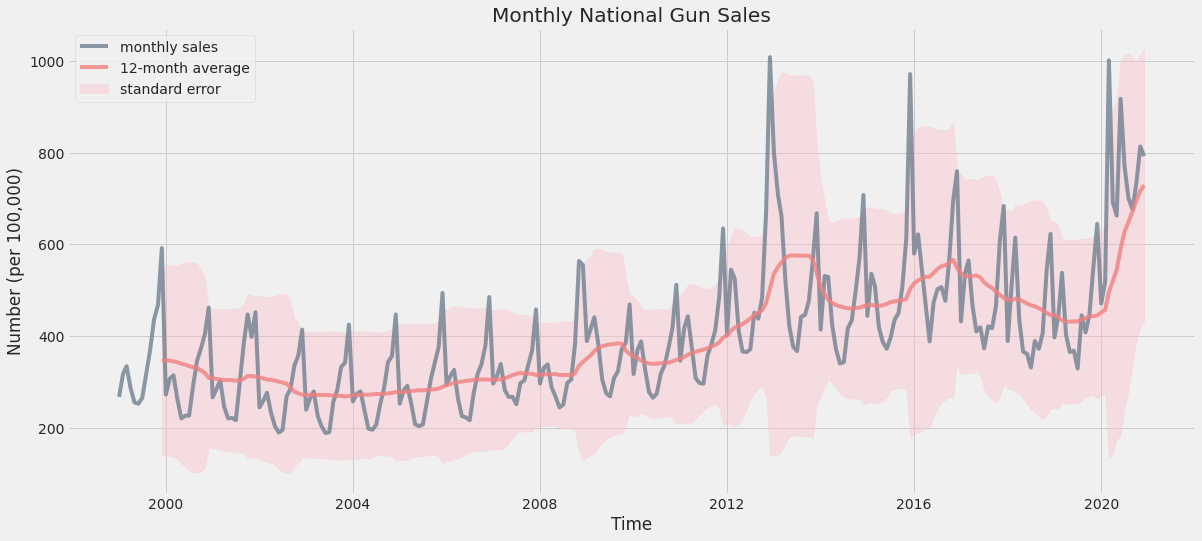

In [15]:
# Plot national total sales
style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(18,8))

sns.lineplot(x=national_sales.index, 
             y='total_sales_per_100000', 
             data=national_sales, 
             color='slategray',
             ax=ax, 
             label='monthly sales',
             alpha=0.8)

rolling_national_sales = national_sales.rolling(12).mean()
sns.lineplot(x=national_sales.index, 
             y='total_sales_per_100000', 
             data=rolling_national_sales, 
             color='lightcoral',
             ax=ax, 
             label='12-month average', 
             alpha=0.8)

rolling_std = national_sales['total_sales_per_100000'].rolling(12).std().to_frame()
ax.fill_between(national_sales.index, 
                rolling_national_sales['total_sales_per_100000'] + (2 * rolling_std['total_sales_per_100000']), 
                rolling_national_sales['total_sales_per_100000'] - (2 * rolling_std['total_sales_per_100000']), 
                color='pink', alpha=0.4, 
                label="standard error")

ax.set(title='Monthly National Gun Sales', xlabel='Time', ylabel='Number (per 100,000)')
ax.legend()

## 8. Rolling Mean and Yearly Average

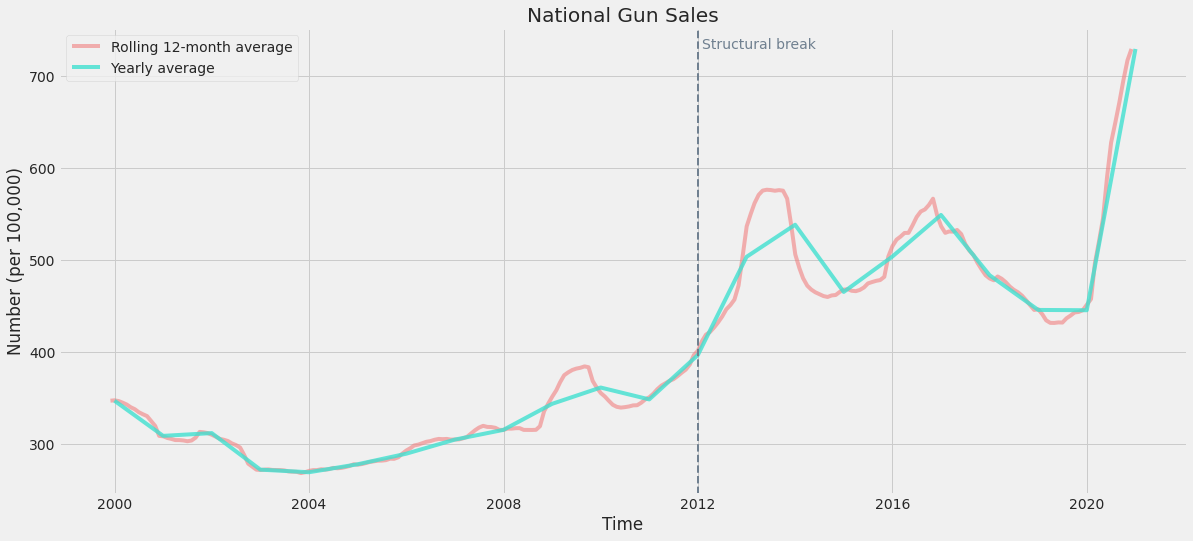

In [16]:
# Plot national total sales
style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(18,8))

# Monthly rolling 12-month average
rolling_national_sales = national_sales.rolling(12).mean().dropna() # first 12 months will be NaN, let's drop them

sns.lineplot(x=rolling_national_sales.index, 
             y='total_sales_per_100000', 
             data=rolling_national_sales, 
             color='lightcoral',
             ax=ax, 
             label='Rolling 12-month average', 
             alpha=0.6)


# Yearly average
sales_yearly_average = national_sales.resample('Y').mean().dropna() # first 12 months will be NaN, let's drop them

sns.lineplot(x=sales_yearly_average.index, 
             y='total_sales_per_100000', 
             data=sales_yearly_average, 
             color='turquoise',
             ax=ax, 
             label='Yearly average', 
             alpha=0.8)

ax.set(title='National Gun Sales', xlabel='Time', ylabel='Number (per 100,000)')

ax.axvline(pd.to_datetime('2012-01-01'), color='slategray', lw=2, linestyle='--')
ax.text(pd.to_datetime('2012-01-30'), max(rolling_national_sales['total_sales_per_100000']), 'Structural break', color='slategray')

ax.legend()

## 9. Chow Test

In [17]:
# Create separate month and year columns so we can plot seasonality by year and month
sales_yearly_average.reset_index(inplace=True)
sales_yearly_average = sales_yearly_average.assign(year = lambda x: x['month_stamp'].dt.year,
                                                       month = lambda x: x['month_stamp'].dt.month)

sales_yearly_average.head()

,month_stamp,handgun_sales,long_gun_sales,multiple_gun_sales,total_sales,total_pop,pop_over_18,handgun_sales_per_100000,long_gun_sales_per_100000,multiple_gun_sales_per_100000,total_sales_per_100000,year,month
0,1999-12-31,232126.000000,478140.583333,17278.166667,727544.750000,2.793276e+08,209495687.5,110.250000,227.583333,7.833333,346.666667,1999,12
1,2000-12-31,200507.833333,438031.250000,15946.833333,654485.916667,2.823984e+08,211798812.5,94.083333,206.250000,6.916667,308.416667,2000,12
2,2001-12-31,198086.666667,452994.250000,16164.000000,667244.916667,2.852252e+08,213918875.0,92.000000,211.083333,7.083333,311.416667,2001,12
3,2002-12-31,168485.166667,404032.833333,15482.000000,588000.000000,2.879546e+08,215965937.5,77.416667,186.583333,6.500000,271.666667,2002,12
4,2003-12-31,169068.833333,401610.500000,16505.666667,587185.000000,2.906262e+08,217969687.5,77.083333,183.666667,7.166667,268.833333,2003,12


In [26]:
# Chow test equation: https://en.wikipedia.org/wiki/Chow_test
# Test statistic follows f distribution with k and N1+N2-2k degrees of freedom

def chow_test(df, breakpoint):
  
  # Pooled regression of sales with year
  result_pooled = sm.OLS(df['total_sales_per_100000'], df['year']).fit()
  ssr_pooled = result_pooled.ssr

  # Regression for each period
  before = df[df['year'] < breakpoint]
  after = df[df['year'] >= breakpoint]
  
  result_before = sm.OLS(before['total_sales_per_100000'], before['year']).fit()
  result_after = sm.OLS(after['total_sales_per_100000'], after['year']).fit()
  
  ssr_1 = result_before.ssr
  ssr_2 = result_after.ssr

  k = 2 # degrees of freedom: slope and intercept
  N1 = len(before) # number of observations before break
  N2 = len(after) # number of observations after break
  chow = ((ssr_pooled - (ssr_1 + ssr_2)) / k) / ((ssr_1 + ssr_2) / (N1+N2-2*k))

  return print('Chow test statistic: ', chow)

chow_test(sales_yearly_average, 2012)

Chow test statistic:  23.804724799412604


In [27]:
# F critical value, test statistic follows f distribution with k and N1+N2-2k degrees of freedom
critical_value = scipy.stats.f.ppf(q=0.99, dfn=k, dfd= N1+N2 -(2*k))
critical_value

6.012904834800529

Chow test statistic 23.80 is greater than the critical value 6.01, meaning we can reject the null hypothesis and accept the alternative hypothesis that the two subperiods are structurally different. 

## 10. Volatility

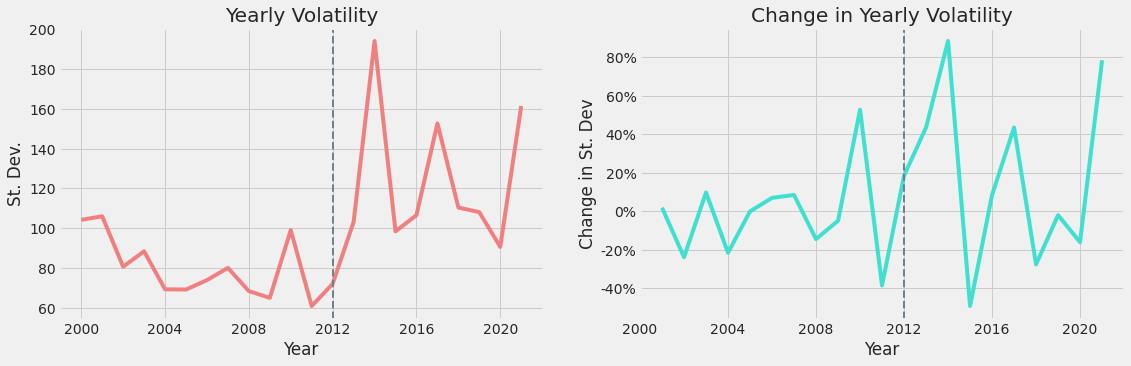

In [24]:
rolling = national_sales.rolling(12)
volatility = rolling.std().dropna()
volatility_mean = volatility.resample('Y').mean()

# Plot
fig = plt.figure(figsize=(17,5)) 
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2) 

ax1.plot(volatility_mean['total_sales_per_100000'], color='lightcoral')
ax1.set(title='Yearly Volatility', xlabel='Year', ylabel='St. Dev.')
ax1.axvline(pd.to_datetime('2012-01-01'), color='slategray', lw=2, linestyle='--')

ax2.plot(volatility_mean['total_sales_per_100000'].pct_change()*100, color='turquoise')
ax2.set(title='Change in Yearly Volatility', xlabel='Year', ylabel='Change in St. Dev')
ax2.axvline(pd.to_datetime('2012-01-01'), color='slategray', lw=2, linestyle='--')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.show()

## 11. References
https://learn.datacamp.com/skill-tracks/applied-finance-in-python

https://medium.com/@remycanario17/the-chow-test-dealing-with-heterogeneity-in-python-1b9057f0f07a

https://en.wikipedia.org/wiki/Chow_test

https://github.com/BuzzFeedNews/nics-firearm-background-checks

https://github.com/nytimes/gunsales